In [4]:
data_dir = '/media/guillaume/Anna-HardDisk/JPK/170216_myoblast/processed/csg11_myoblasts-data-2017.02.16-09.48.23.962_processed-2017.02.16-10.19.09/processed_curves-2017.02.16-10.19.09'


In [76]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [5]:
ls {data_dir}

csg11_myoblasts-data-2017.02.16-09.48.23.962_00000.txt*
csg11_myoblasts-data-2017.02.16-09.48.23.962_00001.txt*
csg11_myoblasts-data-2017.02.16-09.48.23.962_00002.txt*
csg11_myoblasts-data-2017.02.16-09.48.23.962_00003.txt*
csg11_myoblasts-data-2017.02.16-09.48.23.962_00004.txt*
csg11_myoblasts-data-2017.02.16-09.48.23.962_00005.txt*
csg11_myoblasts-data-2017.02.16-09.48.23.962_00006.txt*
csg11_myoblasts-data-2017.02.16-09.48.23.962_00007.txt*
csg11_myoblasts-data-2017.02.16-09.48.23.962_00008.txt*
csg11_myoblasts-data-2017.02.16-09.48.23.962_00009.txt*
csg11_myoblasts-data-2017.02.16-09.48.23.962_00010.txt*
csg11_myoblasts-data-2017.02.16-09.48.23.962_00011.txt*
csg11_myoblasts-data-2017.02.16-09.48.23.962_00012.txt*
csg11_myoblasts-data-2017.02.16-09.48.23.962_00013.txt*
csg11_myoblasts-data-2017.02.16-09.48.23.962_00014.txt*
csg11_myoblasts-data-2017.02.16-09.48.23.962_00015.txt*
csg11_myoblasts-data-2017.02.16-09.48.23.962_00016.txt*
csg11_myoblasts-data-2017.02.16-09.48.23.962_000

In [50]:
data0 = 'csg11_myoblasts-data-2017.02.16-09.48.23.962_00277.txt'

In [51]:
data_path = os.path.join(data_dir, data0)
os.path.exists(data_path)

True

In [52]:
!head -n 100 {data_path}

In [53]:
%pdb

Automatic pdb calling has been turned ON


In [114]:
def parse_header(data_path):
    """ Parses the header of the data files generated by the
    force mapping experiment

    """
    metadata = {}
    with open(data_path, 'r+') as data_file:
        for line in data_file:
            if line.startswith('#'):
                parse_line(line, metadata)
            else:
                break
    return metadata


def parse_line(line, metadata):
    if not ':' in line:
        return
    
    key, *value = line.split(':')
    value = ''.join(value)
    value = value.replace('\n', '')
    value = value[1:]
    
    key = key.replace('# ', '')
    
    metadata[key] = value
    
metadata = parse_header(data_path)

# Tip's half angle theta
metadata['halfAngle'] = 11 * np.pi / 180

In [127]:
exp0 = pd.read_csv(data_path, sep=' ',
                   header=None,
                   comment='#')
exp0.columns = metadata['columns'].split(' ')
exp0 = exp0.loc[:exp0.shape[0]//2]

In [101]:
exp0.head()

,smoothedMeasuredHeight,vDeflection,height,measuredHeight,seriesTime,time
0,0.000003,-0.366123,0.000005,0.000003,8.334445e-07,8.334445e-07
1,0.000003,-0.363152,0.000005,0.000003,2.500333e-06,2.500333e-06
2,0.000003,-0.362786,0.000005,0.000003,4.167222e-06,4.167222e-06
3,0.000003,-0.363060,0.000005,0.000003,5.834111e-06,5.834111e-06
4,0.000003,-0.363152,0.000005,0.000003,7.501000e-06,7.501000e-06


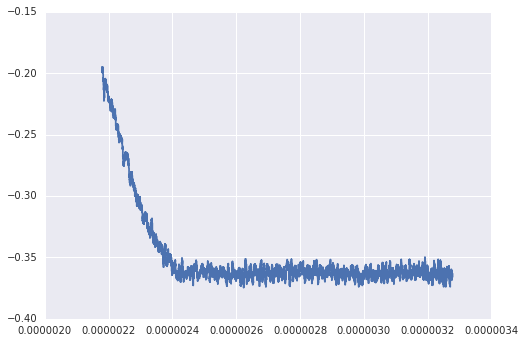

In [102]:
fig, ax = plt.subplots()
ax.plot(exp0['measuredHeight'],
        exp0['vDeflection'], '-')

https://en.wikipedia.org/wiki/Contact_mechanics#Contact_between_a_rigid_conical_indenter_and_an_elastic_half-space

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

In [146]:
def get_identation_force(pixel_data, metadata, frac=10):
    
    height = pixel_data['measuredHeight'].copy()
    height -= height.iloc[-1]
    deflection = pixel_data['vDeflection'] * np.float(metadata['sensitivity'])
    
    heigher = height.max() -  height.ptp()/frac
    flat_segment = pixel_data[height > heigher].index
    deflection = deflection - deflection.loc[flat_segment].mean()
    
    indentation = (height - deflection)
    indentation = indentation.max() - indentation
    spring_constant = np.float(metadata['springConstant'])
    force = deflection * spring_constant
    constant = 2 / (np.pi * (0.75) * np.tan(metadata['halfAngle']))
    
    return indentation.values, force.values, constant

def error_func(indentation, force,
               contact_point, E, constant):
    
    residual = np.zeros_like(indentation)
    cut = np.where(indentation < contact_point)[0][-1]
    residual[:cut] = force[:cut]
    residual[cut:] = force[cut:] - obj_func(identation[cut:],
                                            E, constant)
    return residual
    
def obj_func(identation, E, constant):
    return E * constant * identation**2
    
    
    
    
    

In [155]:
from scipy.optimize import leastsq

In [ ]:
leastsq()

In [154]:
np.tan(metadata['halfAngle'])

0.19438030913771848

In [153]:
np.where(indentation < contact_point)[0][-1]

5542

In [147]:
indentation, force =  get_identation_force(exp0, metadata)

In [149]:
contact_point = 8e-7
force[indentation < contact_point]

array([ -4.00980840e-11,  -2.28602593e-12,   2.36803798e-12, ...,
        -4.76608266e-11,  -3.71896600e-11,  -3.83533350e-11])

In [131]:
height, deflection = substract_base_line(exp0, metadata)

In [116]:
exp0.shape

(7500, 6)

In [135]:
indentation = (height - deflection)
indentation = indentation.max() - indentation
spring_constant = np.float(metadata['springConstant'])

force = deflection * spring_constant

In [151]:
indentation < contact_point

array([ True,  True,  True, ..., False, False, False], dtype=bool)

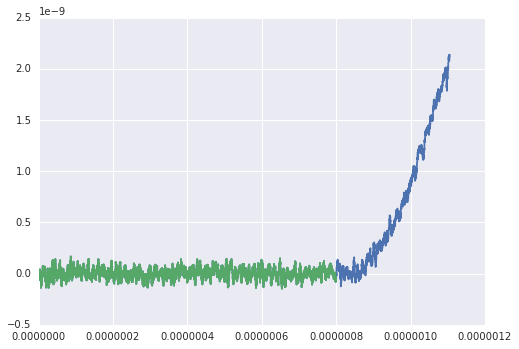

In [150]:
fig, ax = plt.subplots()

ax.plot(indentation, force)
ax.plot(indentation[indentation < contact_point],
        force[indentation < contact_point])
#ax.set_yscale('log')
#ax.set_ylim((5e-11, 6e-9))
#ax.set_xlim((8e-7, 11e-7))

In [ ]:

def analyse_pixel_data(data_path, metadata):f
    
    exp = pd.read_csv(data_path, sep=' ',
                      header=None,
                      comment='#')
    exp.columns = metadata['columns'].split(' ')
    
